# Calcul détaillé de l'ordre de convergence

## Définitions

In [1]:
import time
from matplotlib import pyplot
import numpy
import pandas
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from matplotlib import pyplot, cm

In [2]:
import Conjugate_Gradient as cg

In [3]:
def bilaplacian(p,dx):
        
    N = p.shape[0]
    Ap = numpy.zeros((N,N))
    
    Ap[2:-2,2:-2] = 20*p[2:-2,2:-2]-8*(p[1:-3,2:-2]+p[2:-2,1:-3]+p[2:-2,3:-1]+p[3:-1,2:-2])+\
                    2*(p[1:-3,1:-3]+p[1:-3,3:-1]+p[3:-1,1:-3]+p[3:-1,3:-1])+\
                    1*(p[:-4,2:-2]+p[2:-2,:-4]+p[2:-2,4:]+p[4:,2:-2])
    
    return Ap/dx**4

In [4]:
def impose_bc(p,dy):
    
    p0 = p.copy()
    N = len(p)
    
    p[:,1]      =       0 + 1/4*p0[:,2]
    p[:,N-2]    =       0 + 1/4*p0[:,N-2]
    p[1,2:-2]   =       0 + 1/4*p0[2,2:-2]
    p[N-2,2:-2] = -1/2*dy + 1/4*p0[N-2,2:-2]

In [5]:
def conjugate_gradient_2d(p, b, dx, l1_target):
    '''Performs cg relaxation
    Assumes Dirichlet boundary conditions p=0
    
    Parameters:
    ----------
    p : 2D array of floats
        Initial guess
    b : 2D array of floats
        Source term
    dx: float
        Mesh spacing (same in both directions)
    l1_target: float
        exit criterion
        
    Returns:
    -------
    p: 2D array of float
        Distribution after relaxation
    '''
    N = p.shape[0]
    r  = numpy.zeros((N,N)) # residual
    Ad  = numpy.zeros((N,N)) # to store result of matrix multiplication 
    
    l1_norm = 1
    iterations = 0
    l1_conv = []
    
    # Step-0 We compute the initial residual and 
    # the first search direction is just this residual
    
    r = b-bilaplacian(p,dx)
    d = r.copy()
    rho = numpy.sum(r*r)
    Ad = bilaplacian(d,dx)
    sigma = numpy.sum(d*Ad)
    
    # Iterations
    while l1_norm > l1_target:

        pk = p.copy()
        rk = r.copy()
        dk = d.copy()
        
        alpha = rho/sigma

        p = pk + alpha*dk
        r = rk- alpha*Ad
        
        rhop1 = numpy.sum(r*r)
        beta = rhop1 / rho
        rho = rhop1
        
        d = r + beta*dk
        Ad = bilaplacian(d,dx)
        sigma = numpy.sum(d*Ad)
        
        # Affirme les conditions aux bords
        impose_bc(p,dx)
    
        l1_norm = cg.L1norm(pk,p)
        iterations += 1
        l1_conv.append(l1_norm)
    
    print('Number of CG iterations: {0:d}'.format(iterations))
    return p, l1_conv   

## Calcul

In [14]:
nx_values = [11, 16, 21, 31, 41, 61, 81, 121, 161, 241, 321, 481, 641, 961, 1281, 1921, 2561, 3841, 5121, 7681, 10241]
l1_target = 1e-8
L = 1

dx = numpy.zeros(len(nx_values))
for i in range(len(dx)):
    dx[i] = L/(nx_values[i]-1)

In [15]:
start=time.time()

error = numpy.empty(len(nx_values)-1)

b = 0

p0 = numpy.zeros((nx_values[-1],nx_values[-1]))
impose_bc(p0,dx[i])
p_precis, l1_conv = conjugate_gradient_2d(p0, b, dx[-1], l1_target)
p_precis_centre = p_precis[int(nx_values[-1]/2),int(nx_values[-1]/2)]

for i, nx in enumerate(nx_values[:-1]):
    
    p0 = numpy.zeros((nx,nx))
    impose_bc(p0,dx[i])
    p, l1_conv = conjugate_gradient_2d(p0, b, dx[i], l1_target)
    p_centre = p[int(nx/2),int(nx/2)]
    error[i] = numpy.abs(p_centre-p_precis_centre)
    
    # save to file
        
    dataError = list(zip(error))
    df = pandas.DataFrame(data = dataError, columns=['Error'])
    df.to_csv("dataError.csv",index=False,header=True)
    
    print("currently at nx={:d}".format(nx))
    
print("Execution time is {:.3f} seconds".format(time.time()-start))

Number of CG iterations: 2599
Number of CG iterations: 29
currently at nx=11
Number of CG iterations: 75
currently at nx=16
Number of CG iterations: 146
currently at nx=21
Number of CG iterations: 358
currently at nx=31
Number of CG iterations: 648
currently at nx=41
Number of CG iterations: 1456
currently at nx=61


In [16]:
dataError = pandas.read_csv('dataError.csv')
[error] = numpy.transpose(dataError.as_matrix(['Error']))
print(error)

[ 0.00442996  0.00611675  0.00134424  0.00068464  0.00040006  0.00013185]


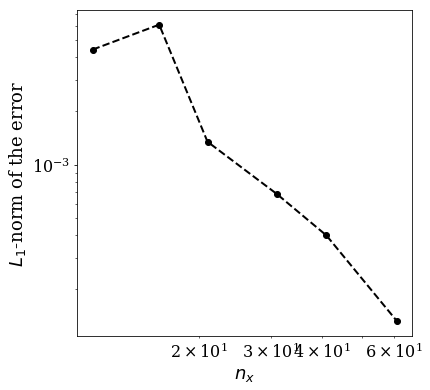

In [17]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$n_x$', fontsize=18)
pyplot.ylabel(r'$L_1$-norm of the error', fontsize=18)

pyplot.loglog(nx_values[:-1], error, color='k', ls='--', lw=2, marker='o');
pyplot.grid()

In [18]:
alphas = numpy.empty(len(nx_values)-2)

for i in range(len(alphas)):
    
    alphas[i] = (numpy.log(error[i+1])-numpy.log(error[i]))\
        /(numpy.log(nx_values[i+1])-numpy.log(nx_values[i]))
    
print(alphas)

[ 0.86107849 -5.57194412 -1.73234471 -1.9217531  -2.79371075]
